In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
from urllib.parse import urljoin
import matplotlib.pyplot as plt
import seaborn as sns
from pymongo import MongoClient
import streamlit as st
import pandas as pd
from pymongo import MongoClient

In [2]:
BASE_URL = 'https://books.toscrape.com/'

In [3]:
def get_genre_links():
    response = requests.get(BASE_URL)
    soup = BeautifulSoup(response.text, 'html.parser')
    genre_section = soup.find('ul', class_='nav-list')
    genre_links = genre_section.find_all('a')
    genres = {}
    for link in genre_links[1:]:  # Skip the first link which is 'Books'
        genre_name = link.get_text(strip=True)
        genre_href = link['href']
        full_url = urljoin(BASE_URL, genre_href)
        genres[genre_name] = full_url
    return genres

In [4]:
def get_books_from_genre(genre_url):
    books = []
    while genre_url:
        response = requests.get(genre_url)
        soup = BeautifulSoup(response.text, 'html.parser')
        book_list = soup.find_all('article', class_='product_pod')
        for book in book_list:
            title = book.h3.a['title']
            price = book.find('p', class_='price_color').get_text()
            availability = book.find('p', class_='instock availability').get_text(strip=True)
            rating = book.p['class'][1]
            product_page = urljoin(genre_url, book.h3.a['href'])
            books.append({
                'Title': title,
                'Price': price,
                'Availability': availability,
                'Rating': rating,
                'Product Page': product_page
            })
        # Check for next page
        next_button = soup.find('li', class_='next')
        if next_button:
            next_href = next_button.a['href']
            genre_url = urljoin(genre_url, next_href)
        else:
            genre_url = None
    return books

In [5]:
def scrape_all_books():
    all_books = []
    genres = get_genre_links()
    for genre, url in genres.items():
        print(f"Scraping genre: {genre}")
        books = get_books_from_genre(url)
        for book in books:
            book['Genre'] = genre
        all_books.extend(books)
    return all_books


In [6]:
books_data = scrape_all_books()
df = pd.DataFrame(books_data)
df.to_csv('books.csv', index=False)
print("Scraping completed. Data saved to books.csv.")

Scraping genre: Travel
Scraping genre: Mystery
Scraping genre: Historical Fiction
Scraping genre: Sequential Art
Scraping genre: Classics
Scraping genre: Philosophy
Scraping genre: Romance
Scraping genre: Womens Fiction
Scraping genre: Fiction
Scraping genre: Childrens
Scraping genre: Religion
Scraping genre: Nonfiction
Scraping genre: Music
Scraping genre: Default
Scraping genre: Science Fiction
Scraping genre: Sports and Games
Scraping genre: Add a comment
Scraping genre: Fantasy
Scraping genre: New Adult
Scraping genre: Young Adult
Scraping genre: Science
Scraping genre: Poetry
Scraping genre: Paranormal
Scraping genre: Art
Scraping genre: Psychology
Scraping genre: Autobiography
Scraping genre: Parenting
Scraping genre: Adult Fiction
Scraping genre: Humor
Scraping genre: Horror
Scraping genre: History
Scraping genre: Food and Drink
Scraping genre: Christian Fiction
Scraping genre: Business
Scraping genre: Biography
Scraping genre: Thriller
Scraping genre: Contemporary
Scraping genr

In [7]:
df.head()
df.dtypes

Title           object
Price           object
Availability    object
Rating          object
Product Page    object
Genre           object
dtype: object

In [8]:
#clean the price column
import re
def clean_price(price):
    # Extract numeric part (e.g., '45.17' from 'Â£45.17')
    match = re.search(r'\d+\.\d{2}', price)
    return float(match.group()) if match else None

df['Price'] = df['Price'].apply(clean_price)

In [9]:
df.head()
df.dtypes

Title            object
Price           float64
Availability     object
Rating           object
Product Page     object
Genre            object
dtype: object

In [10]:
#clean titles
def clean_title(title):
    # Replace problematic characters (e.g., â with ')
    title = re.sub(r'â', "'", title)
    # Remove extra whitespace
    title = re.sub(r'\s+', ' ', title).strip()
    return title

df['Title'] = df['Title'].apply(clean_title)

In [11]:
df.head()

,Title,Price,Availability,Rating,Product Page,Genre
0,It's Only the Himalayas,45.17,In stock,Two,https://books.toscrape.com/catalogue/its-only-...,Travel
1,Full Moon over Noah's Ark: An Odyssey to Mount...,49.43,In stock,Four,https://books.toscrape.com/catalogue/full-moon...,Travel
2,See America: A Celebration of Our National Par...,48.87,In stock,Three,https://books.toscrape.com/catalogue/see-ameri...,Travel
3,Vagabonding: An Uncommon Guide to the Art of L...,36.94,In stock,Two,https://books.toscrape.com/catalogue/vagabondi...,Travel
4,Under the Tuscan Sun,37.33,In stock,Three,https://books.toscrape.com/catalogue/under-the...,Travel


In [12]:
# check for missing values
missing_values = df.isnull().sum()
print(missing_values)
#check for duplicates
duplicates = df.duplicated().sum()
print(duplicates)

Title           0
Price           0
Availability    0
Rating          0
Product Page    0
Genre           0
dtype: int64
0


In [13]:
#Analysis 

#Genre Distribution: Count the number of books per genre.
genre_counts = df['Genre'].value_counts()
print(genre_counts)

Genre
Default               152
Nonfiction            110
Sequential Art         75
Add a comment          67
Fiction                65
Young Adult            54
Fantasy                48
Romance                35
Mystery                32
Food and Drink         30
Childrens              29
Historical Fiction     26
Classics               19
Poetry                 19
History                18
Womens Fiction         17
Horror                 17
Science Fiction        16
Science                14
Music                  13
Business               12
Travel                 11
Philosophy             11
Thriller               11
Humor                  10
Autobiography           9
Art                     8
Religion                7
Psychology              7
Christian Fiction       6
Spirituality            6
New Adult               6
Sports and Games        5
Biography               5
Self Help               5
Health                  4
Politics                3
Contemporary            3
Christ

In [14]:
#Average Price by Genre: Compare the average price of books across genres.
avg_price_by_genre = df.groupby('Genre')['Price'].mean().sort_values()
print(avg_price_by_genre)

Genre
Crime                 10.970000
Academic              13.120000
Adult Fiction         15.360000
Paranormal            15.400000
Erotica               19.190000
Historical            22.830000
Food and Drink        31.414667
Thriller              31.433636
Mystery               31.719062
Business              32.460000
Religion              32.567143
Childrens             32.638276
Science               33.088571
Humor                 33.501000
Philosophy            33.558182
Historical Fiction    33.644231
Biography             33.662000
Science Fiction       33.802500
Romance               33.933714
Psychology            34.218571
Nonfiction            34.260182
Christian Fiction     34.385000
Default               34.392697
Sequential Art        34.572267
Spirituality          35.098333
Young Adult           35.449074
Music                 35.636923
Add a comment         35.796418
Short Stories         35.880000
Horror                35.949412
Poetry                35.974211
Fi

In [15]:
# convert rating to numeric 
rating_map = {'One': 1, 'Two': 2, 'Three': 3, 'Four': 4, 'Five': 5}
df['Rating_Numeric'] = df['Rating'].map(rating_map)

In [16]:
#Rating Distribution by Genre: Analyze the average rating or rating distribution per genre
avg_rating_by_genre = df.groupby('Genre')['Rating_Numeric'].mean().sort_values()
print(avg_rating_by_genre)

Genre
Crime                 1.000000
Cultural              1.000000
Paranormal            1.000000
Short Stories         1.000000
Psychology            1.714286
Academic              2.000000
Parenting             2.000000
Biography             2.200000
Science Fiction       2.250000
Politics              2.333333
Contemporary          2.333333
Philosophy            2.363636
Classics              2.473684
Self Help             2.600000
Childrens             2.620690
Romance               2.628571
Christian             2.666667
Horror                2.705882
Thriller              2.727273
Travel                2.727273
Add a comment         2.761194
Default               2.835526
Nonfiction            2.881818
Food and Drink        2.900000
Business              2.916667
Science               2.928571
Mystery               2.937500
History               2.944444
Sequential Art        2.973333
Suspense              3.000000
Autobiography         3.000000
Historical            3.000000
Sp

In [17]:
#Most Expensive/Cheapest Books: Find the top 5 most expensive and cheapest books.
print("Most Expensive Books:")
print(df[['Title', 'Price', 'Genre']].nlargest(5, 'Price'))
print("\nCheapest Books:")
print(df[['Title', 'Price', 'Genre']].nsmallest(5, 'Price'))

Most Expensive Books:
                                  Title  Price           Genre
191  The Perfect Play (Play by Play #1)  59.99         Romance
271   Last One Home (New Beginnings #1)  59.98         Fiction
845    Civilization and Its Discontents  59.95      Psychology
925      The Barefoot Contessa Cookbook  59.92  Food and Drink
368           The Diary of a Young Girl  59.90      Nonfiction

Cheapest Books:
                                                 Title  Price           Genre
781                         An Abundance of Katherines  10.00     Young Adult
804                              The Origin of Species  10.01         Science
666  The Tipping Point: How Little Things Can Make ...  10.02   Add a comment
77                                            Patience  10.16  Sequential Art
497                               Greek Mythic History  10.23         Default


In [18]:
#Highest-Rated Books
top_rated = df[df['Rating_Numeric'] == 5][['Title', 'Genre', 'Price']]
print(top_rated)

                                                 Title      Genre  Price
10                  1,000 Places to See Before You Die     Travel  26.08
19              A Time of Torment (Charlie Parker #14)    Mystery  48.35
28   What Happened on Beale Street (Secrets of the ...    Mystery  25.37
29   The Bachelor Girl's Guide to Murder (Herringfo...    Mystery  52.30
33                   The Silkworm (Cormoran Strike #2)    Mystery  23.05
..                                                 ...        ...    ...
984  (Un)Qualified: How God Uses Broken People to D...  Christian  54.00
989  Suzie Snowflake: One beautiful flake (a self-e...     Novels  54.81
992  10-Day Green Smoothie Cleanse: Lose Up to 15 P...     Health  49.71
993     The Art and Science of Low Carbohydrate Living     Health  52.98
998                                         Dark Notes    Erotica  19.19

[196 rows x 3 columns]


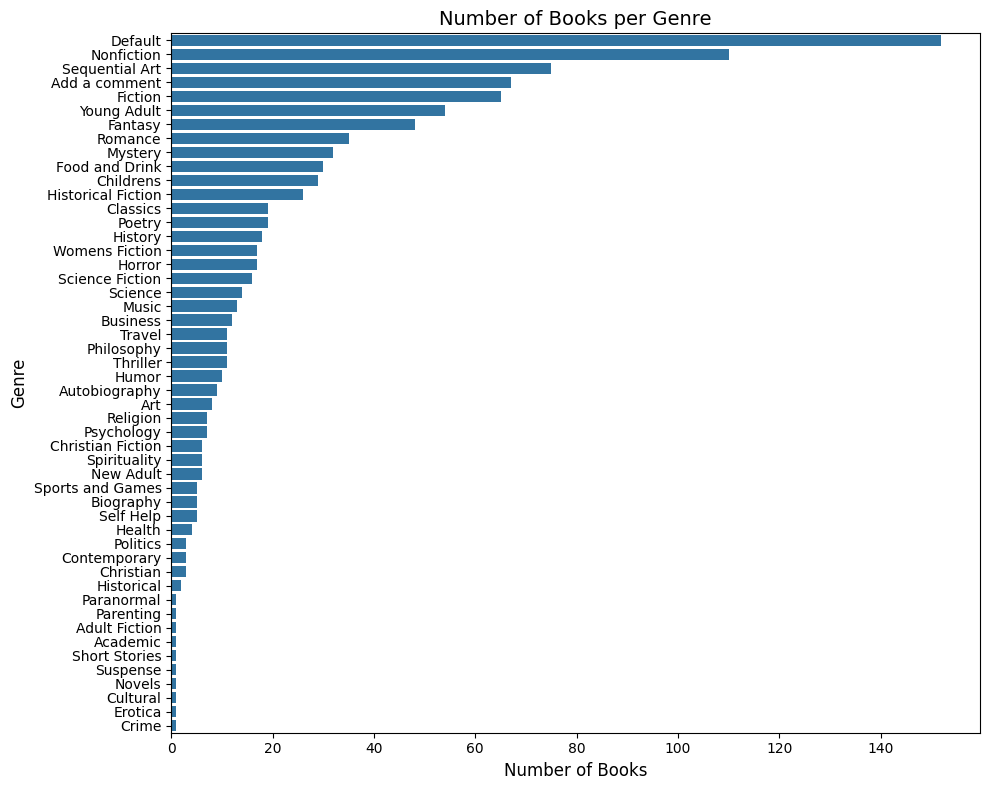

In [19]:
# Visualization 1: Bar Plot - Number of Books per Genre
plt.figure(figsize=(10, 8))
genre_counts = df['Genre'].value_counts()
sns.barplot(x=genre_counts.values, y=genre_counts.index)
plt.title('Number of Books per Genre', fontsize=14)
plt.xlabel('Number of Books', fontsize=12)
plt.ylabel('Genre', fontsize=12)
plt.tight_layout()
plt.savefig('genre_bar_plot.png', dpi=300, bbox_inches='tight')
plt.show()

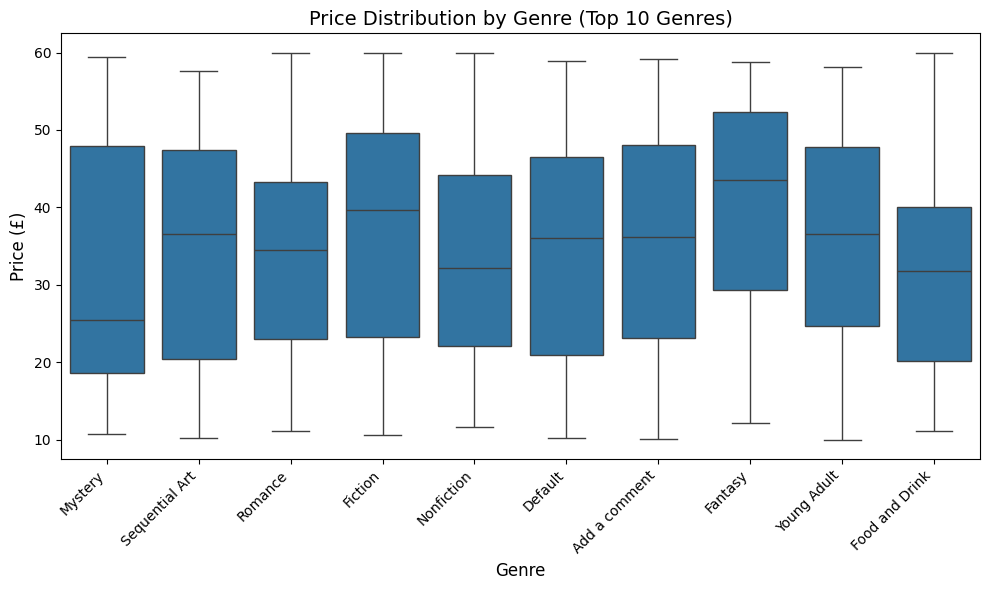

In [20]:
# Visualization 2: Box Plot - Price Distribution by Genre (Top 10 Genres)
plt.figure(figsize=(10, 6))
# Filter top 10 genres by book count to make the plot readable
top_genres = genre_counts.head(10).index
df_top_genres = df[df['Genre'].isin(top_genres)]
sns.boxplot(x='Genre', y='Price', data=df_top_genres)
plt.title('Price Distribution by Genre (Top 10 Genres)', fontsize=14)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Price (£)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('price_box_plot.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\Ahmedhelmy\AppData\Local\Temp\ipykernel_10116\3234671763.py:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


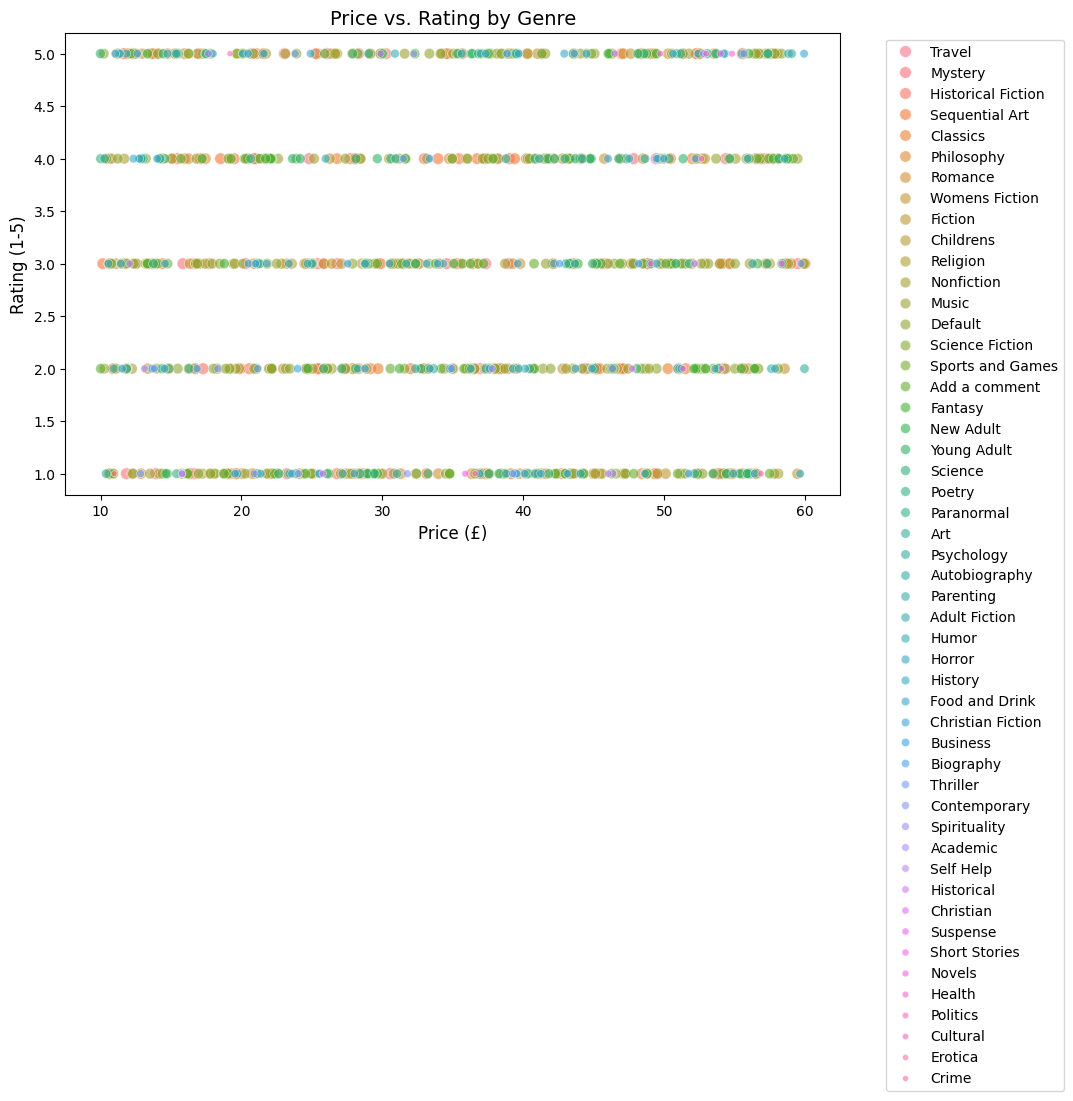

In [21]:
# Visualization 3: Scatter Plot - Price vs. Rating
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Price', y='Rating_Numeric', hue='Genre', size='Genre', data=df, alpha=0.6)
plt.title('Price vs. Rating by Genre', fontsize=14)
plt.xlabel('Price (£)', fontsize=12)
plt.ylabel('Rating (1-5)', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

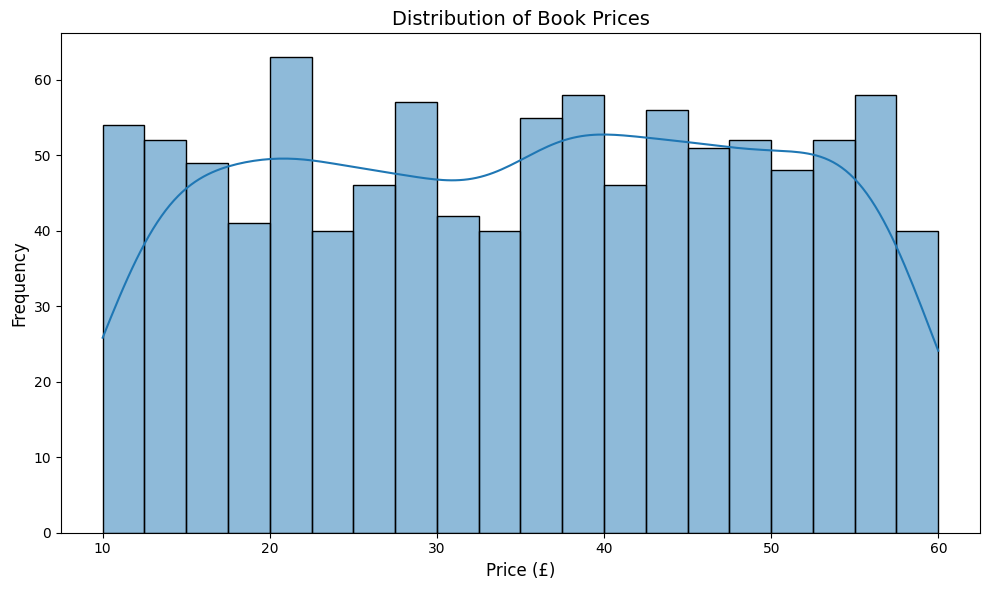

In [22]:
# Visualization 4: Histogram - Distribution of Book Prices
plt.figure(figsize=(10, 6))
sns.histplot(df['Price'], bins=20, kde=True)
plt.title('Distribution of Book Prices', fontsize=14)
plt.xlabel('Price (£)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.savefig('price_histogram.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Connect to the database
client = MongoClient('mongodb://localhost:27017/')  
db = client['Library']  
collection = db['books']  
# Clear existing data
collection.delete_many({})
# Convert DataFrame to list of dictionaries
records = df.to_dict(orient='records')

# Insert the data into MongoDB
collection.insert_many(records)
print("Data successfully stored in MongoDB.")

Data successfully stored in MongoDB.
